# EDA: Ecclesiastical Schematisms Dataset Analysis

This notebook analyzes the dataset to identify potential issues with class distribution and data quality that might be causing training problems.

In [14]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette('husl')

In [31]:
meaningful_labels = {"B-parish", "I-parish", "B-deanery", "I-deanery", "B-dedication", "I-dedication", "B-building_material", "I-building_material"}

def is_truly_positive(example):
    return any(label in meaningful_labels for label in example["labels"])


In [32]:
dataset = dataset.filter(is_truly_positive)

Filter:   0%|          | 0/158 [00:00<?, ? examples/s]

In [33]:
dataset

Dataset({
    features: ['image_pil', 'image', 'width', 'height', 'words', 'bboxes', 'labels', 'conf'],
    num_rows: 52
})

In [ ]:
# Load dataset
dataset = load_dataset("artpods56/EcclesialSchematisms", "default", split="train", token="token", trust_remote_code=True, num_proc=8)
print(f"Dataset size: {len(dataset)}")
print(f"Dataset features: {dataset.features}")

Dataset size: 158
Dataset features: {'image_pil': Image(mode=None, decode=True, id=None), 'image': Value(dtype='string', id=None), 'width': Value(dtype='int32', id=None), 'height': Value(dtype='int32', id=None), 'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'conf': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None)}


In [28]:
sample = dataset[0]
sample["labels"]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
dataset = dataset.filter()

## 1. Basic Dataset Information

In [16]:
# Examine first example
example = dataset[0]
print("First example structure:")
for key, value in example.items():
    if key == 'image_pil':
        print(f"{key}: {type(value)} - {value.size if hasattr(value, 'size') else 'N/A'}")
    elif isinstance(value, list):
        print(f"{key}: {type(value)} - length: {len(value)}")
        if len(value) > 0:
            print(f"  Sample values: {value[:3]}...")
    else:
        print(f"{key}: {type(value)} - {value}")

First example structure:
image_pil: <class 'PIL.PngImagePlugin.PngImageFile'> - (764, 1240)
image: <class 'str'> - chelmno_1871_0000a.jpg
width: <class 'int'> - 764
height: <class 'int'> - 1240
words: <class 'list'> - length: 27
  Sample values: ['i', 'N', '1']...
bboxes: <class 'list'> - length: 27
  Sample values: [[870, 73, 882, 75], [608, 308, 802, 396], [553, 877, 557, 887]]...
labels: <class 'list'> - length: 27
  Sample values: ['O', 'O', 'O']...
conf: <class 'list'> - length: 27
  Sample values: [40.0, 75.0, 78.0]...


## 2. Label Analysis - This is Critical!

In [17]:
# Collect all labels from all examples
all_labels = []
all_words = []
num_tokens_per_example = []

for example in dataset:
    labels = example['labels']
    words = example['words']
    
    all_labels.extend(labels)
    all_words.extend(words)
    num_tokens_per_example.append(len(labels))

print(f"Total number of tokens across dataset: {len(all_labels)}")
print(f"Average tokens per example: {np.mean(num_tokens_per_example):.1f}")
print(f"Min tokens per example: {min(num_tokens_per_example)}")
print(f"Max tokens per example: {max(num_tokens_per_example)}")

Total number of tokens across dataset: 27693
Average tokens per example: 175.3
Min tokens per example: 0
Max tokens per example: 290


In [18]:
# Count label distribution
label_counts = Counter(all_labels)
print("Label distribution:")
for label, count in sorted(label_counts.items()):
    percentage = (count / len(all_labels)) * 100
    print(f"Label {label}: {count:,} tokens ({percentage:.2f}%)")

# Check for potential issues
unique_labels = sorted(label_counts.keys())
print(f"\nUnique labels: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")

Label distribution:
Label B-building_material: 120 tokens (0.43%)
Label B-deanery: 14 tokens (0.05%)
Label B-dedication: 159 tokens (0.57%)
Label B-material: 8 tokens (0.03%)
Label B-page_number: 87 tokens (0.31%)
Label B-parish: 152 tokens (0.55%)
Label B-parish_dedication: 2 tokens (0.01%)
Label B-settlement_classification: 1 tokens (0.00%)
Label I-building_material: 21 tokens (0.08%)
Label I-deanery: 12 tokens (0.04%)
Label I-dedication: 317 tokens (1.14%)
Label I-parish: 42 tokens (0.15%)
Label I-parish_dedication: 1 tokens (0.00%)
Label O: 26,757 tokens (96.62%)

Unique labels: ['B-building_material', 'B-deanery', 'B-dedication', 'B-material', 'B-page_number', 'B-parish', 'B-parish_dedication', 'B-settlement_classification', 'I-building_material', 'I-deanery', 'I-dedication', 'I-parish', 'I-parish_dedication', 'O']
Number of unique labels: 14


## 2.1. Positive Examples Analysis

In [19]:
# Filter out examples that only have 'O' labels or only 'page_number' labels
print("🔍 Analyzing positive examples (excluding page_number-only examples)...")

positive_examples = []
page_number_only_examples = []
no_labels_examples = []
empty_examples = []

for i, example in enumerate(dataset):
    labels = example['labels']
    words = example['words']
    
    # Skip empty examples
    if len(labels) == 0:
        empty_examples.append(i)
        continue
    
    # Get non-O labels
    non_o_labels = [label for label in labels if label != 'O']
    
    if len(non_o_labels) == 0:
        # Only 'O' labels
        no_labels_examples.append(i)
    elif all(label.endswith('page_number') for label in non_o_labels):
        # Only page_number labels
        page_number_only_examples.append(i)
    else:
        # Has meaningful labels beyond page numbers
        positive_examples.append(i)

print(f"📊 Example categorization:")
print(f"Total examples: {len(dataset)}")
print(f"Empty examples (0 tokens): {len(empty_examples)}")
print(f"Examples with only 'O' labels: {len(no_labels_examples)}")
print(f"Examples with only page_number labels: {len(page_number_only_examples)}")
print(f"✅ Positive examples (meaningful content): {len(positive_examples)}")
print(f"")
print(f"Percentage of positive examples: {len(positive_examples)/len(dataset)*100:.1f}%")

🔍 Analyzing positive examples (excluding page_number-only examples)...
📊 Example categorization:
Total examples: 158
Empty examples (0 tokens): 10
Examples with only 'O' labels: 53
Examples with only page_number labels: 43
✅ Positive examples (meaningful content): 52

Percentage of positive examples: 32.9%
📊 Example categorization:
Total examples: 158
Empty examples (0 tokens): 10
Examples with only 'O' labels: 53
Examples with only page_number labels: 43
✅ Positive examples (meaningful content): 52

Percentage of positive examples: 32.9%


In [20]:
# Analyze positive examples in detail
if positive_examples:
    print("🎯 Analyzing positive examples only...")
    
    # Collect labels from positive examples only
    positive_labels = []
    positive_tokens_per_example = []
    
    for idx in positive_examples:
        example = dataset[idx]
        labels = example['labels']
        positive_labels.extend(labels)
        positive_tokens_per_example.append(len(labels))
    
    # Count labels in positive examples
    positive_label_counts = Counter(positive_labels)
    print(f"\nLabel distribution in positive examples only:")
    for label, count in sorted(positive_label_counts.items()):
        percentage = (count / len(positive_labels)) * 100
        print(f"Label {label}: {count:,} tokens ({percentage:.2f}%)")
    
    # Calculate new imbalance ratio excluding page_number and O
    meaningful_labels = {k: v for k, v in positive_label_counts.items() 
                        if k != 'O' and not k.endswith('page_number')}
    
    if meaningful_labels:
        meaningful_percentages = [count/len(positive_labels)*100 for count in meaningful_labels.values()]
        meaningful_max = max(meaningful_percentages)
        meaningful_min = min(meaningful_percentages)
        meaningful_imbalance = meaningful_max / meaningful_min if meaningful_min > 0 else float('inf')
        
        print(f"\n🎯 Meaningful labels imbalance analysis:")
        print(f"Most common meaningful class: {meaningful_max:.2f}%")
        print(f"Least common meaningful class: {meaningful_min:.2f}%")
        print(f"Meaningful classes imbalance ratio: {meaningful_imbalance:.1f}:1")
    
    print(f"\nAverage tokens per positive example: {np.mean(positive_tokens_per_example):.1f}")
else:
    print("⚠️ No positive examples found!")

🎯 Analyzing positive examples only...

Label distribution in positive examples only:
Label B-building_material: 120 tokens (0.98%)
Label B-deanery: 14 tokens (0.11%)
Label B-dedication: 159 tokens (1.30%)
Label B-material: 8 tokens (0.07%)
Label B-page_number: 43 tokens (0.35%)
Label B-parish: 152 tokens (1.24%)
Label B-parish_dedication: 2 tokens (0.02%)
Label B-settlement_classification: 1 tokens (0.01%)
Label I-building_material: 21 tokens (0.17%)
Label I-deanery: 12 tokens (0.10%)
Label I-dedication: 317 tokens (2.59%)
Label I-parish: 42 tokens (0.34%)
Label I-parish_dedication: 1 tokens (0.01%)
Label O: 11,356 tokens (92.72%)

🎯 Meaningful labels imbalance analysis:
Most common meaningful class: 2.59%
Least common meaningful class: 0.01%
Meaningful classes imbalance ratio: 317.0:1

Average tokens per positive example: 235.5

Label distribution in positive examples only:
Label B-building_material: 120 tokens (0.98%)
Label B-deanery: 14 tokens (0.11%)
Label B-dedication: 159 tokens 

In [25]:
# Show some examples of each category
print("📝 Sample examples from each category:")
print("="*50)

# Show a few positive examples
if positive_examples:
    print(f"\n✅ POSITIVE EXAMPLES (first 3):")
    for i, idx in enumerate(positive_examples[:3]):
        example = dataset[idx]
        labels = example['labels']
        words = example['words']
        non_o_labels = [label for label in labels if label != 'O']
        meaningful_labels = [label for label in non_o_labels if not label.endswith('page_number')]
        
        print(f"\nExample {idx} (positive #{i+1}):")
        print(f"  Image: {example['image']}")
        print(f"  Total tokens: {len(labels)}")
        print(f"  Meaningful labels: {Counter(meaningful_labels)}")
        print(f"  Sample words: {words[:10]}...")

# Show page-number-only examples
if page_number_only_examples:
    print(f"\n📄 PAGE-NUMBER-ONLY EXAMPLES (first 2):")
    for i, idx in enumerate(page_number_only_examples[:2]):
        example = dataset[idx]
        labels = example['labels']
        words = example['words']
        non_o_labels = [label for label in labels if label != 'O']
        
        print(f"\nExample {idx} (page-only #{i+1}):")
        print(f"  Image: {example['image']}")
        print(f"  Total tokens: {len(labels)}")
        print(f"  Page number labels: {Counter(non_o_labels)}")
        print(f"  Sample words: {words[:10]}...")

# Show no-label examples
if no_labels_examples:
    print(f"\n❌ NO-LABEL EXAMPLES (first 2):")
    for i, idx in enumerate(no_labels_examples[:2]):
        example = dataset[idx]
        labels = example['labels']
        words = example['words']
        
        print(f"\nExample {idx} (no-labels #{i+1}):")
        print(f"  Image: {example['image']}")
        print(f"  Total tokens: {len(labels)}")
        print(f"  All labels are 'O': {all(label == 'O' for label in labels)}")
        print(f"  Sample words: {words[:10]}...")
        
        
        
print("Summary of analysis:")
print(f"Total dataset size: {len(dataset)}")
print(f"Amount of positive examples: {len(positive_examples)} ({len(positive_examples)/len(dataset)*100:.1f}%)")
print(f"Amout of example with page_number labels only: {len(page_number_only_examples)} ({len(page_number_only_examples)/len(dataset)*100:.1f}%)")
print(f"Amount of examples with no labels: {len(no_labels_examples)} ({len(no_labels_examples)/len(dataset)*100:.1f}%)")

📝 Sample examples from each category:

✅ POSITIVE EXAMPLES (first 3):

Example 4 (positive #1):
  Image: chelmno_1871_0001.jpg
  Total tokens: 30
  Meaningful labels: Counter({'B-parish': 1})
  Sample words: ['H', 'CONSIGNATIO', 'totius', 'Cleri', 'saecularis', 'et', 'regularis,', 'Sororum', 'piarum', 'Congregationum']...

Example 14 (positive #2):
  Image: chelmno_1871_0011.jpg
  Total tokens: 212
  Meaningful labels: Counter({'B-parish': 8, 'B-deanery': 2, 'I-deanery': 2, 'I-parish': 1})
  Sample words: ['11', 'CLERUS', 'IN', 'CURA', 'ANIMARUM,', 'T.', 'Decanatus', 'Fredecensis.', '(Briesen.)', 'Decanus:']...

Example 15 (positive #3):
  Image: chelmno_1871_0012.jpg
  Total tokens: 243
  Meaningful labels: Counter({'B-parish': 9})
  Sample words: ['o', '6.', '~', 'w', '10.', 'è', 'Sypniewo.', 'Par.', 'Franc.', 'Wollsch']...

📄 PAGE-NUMBER-ONLY EXAMPLES (first 2):

Example 3 (page-only #1):
  Image: chelmno_1871_0000d.jpg
  Total tokens: 209
  Page number labels: Counter({'B-page_numb

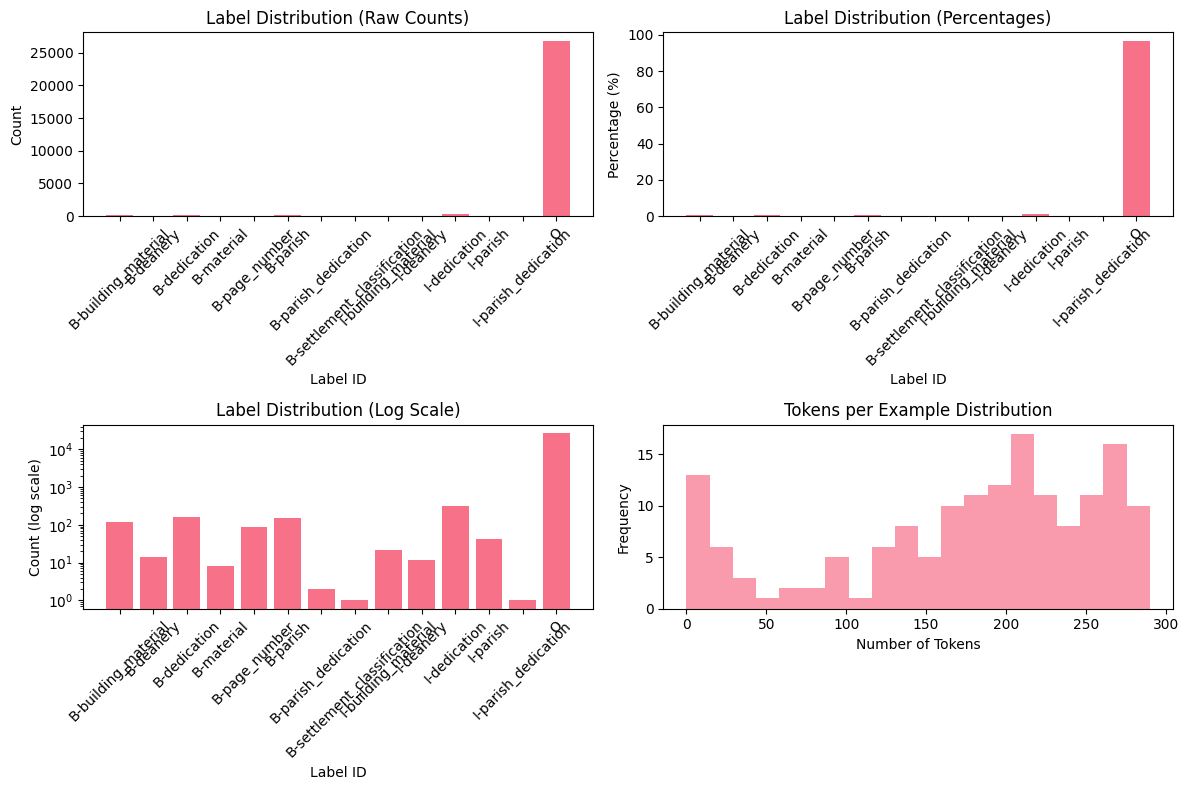

In [22]:
# Create label distribution plot
plt.figure(figsize=(12, 8))

# Plot 1: Label counts
plt.subplot(2, 2, 1)
labels, counts = zip(*sorted(label_counts.items()))
plt.bar(labels, counts)
plt.title('Label Distribution (Raw Counts)')
plt.xlabel('Label ID')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot 2: Label percentages
plt.subplot(2, 2, 2)
percentages = [count/len(all_labels)*100 for count in counts]
plt.bar(labels, percentages)
plt.title('Label Distribution (Percentages)')
plt.xlabel('Label ID')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)

# Plot 3: Log scale
plt.subplot(2, 2, 3)
plt.bar(labels, counts)
plt.yscale('log')
plt.title('Label Distribution (Log Scale)')
plt.xlabel('Label ID')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)

# Plot 4: Tokens per example distribution
plt.subplot(2, 2, 4)
plt.hist(num_tokens_per_example, bins=20, alpha=0.7)
plt.title('Tokens per Example Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## 3. Class Imbalance Analysis

In [23]:
# Calculate class imbalance metrics
total_tokens = len(all_labels)
label_stats = []

for label in sorted(unique_labels):
    count = label_counts[label]
    percentage = (count / total_tokens) * 100
    label_stats.append({
        'label': label,
        'count': count,
        'percentage': percentage
    })

df_stats = pd.DataFrame(label_stats)
print("Detailed label statistics:")
print(df_stats)

# Check for extreme imbalance
max_percentage = df_stats['percentage'].max()
min_percentage = df_stats['percentage'].min()
imbalance_ratio = max_percentage / min_percentage if min_percentage > 0 else float('inf')

print(f"\n🚨 Class Imbalance Analysis:")
print(f"Most common class: {max_percentage:.2f}%")
print(f"Least common class: {min_percentage:.2f}%")
print(f"Imbalance ratio: {imbalance_ratio:.1f}:1")

if imbalance_ratio > 100:
    print("⚠️  SEVERE CLASS IMBALANCE DETECTED! This could be causing training issues.")
elif imbalance_ratio > 10:
    print("⚠️  Moderate class imbalance detected.")
else:
    print("✅ Class distribution is relatively balanced.")

Detailed label statistics:
                          label  count  percentage
0           B-building_material    120    0.433323
1                     B-deanery     14    0.050554
2                  B-dedication    159    0.574152
3                    B-material      8    0.028888
4                 B-page_number     87    0.314159
5                      B-parish    152    0.548875
6           B-parish_dedication      2    0.007222
7   B-settlement_classification      1    0.003611
8           I-building_material     21    0.075831
9                     I-deanery     12    0.043332
10                 I-dedication    317    1.144694
11                     I-parish     42    0.151663
12          I-parish_dedication      1    0.003611
13                            O  26757   96.620084

🚨 Class Imbalance Analysis:
Most common class: 96.62%
Least common class: 0.00%
Imbalance ratio: 26757.0:1
⚠️  SEVERE CLASS IMBALANCE DETECTED! This could be causing training issues.


## 4. Training Issues Diagnosis

In [24]:
print("🩺 Training Issues Diagnosis:")
print("="*50)

issues_found = []

# Check 1: Class imbalance
if imbalance_ratio > 50:
    issues_found.append(f"SEVERE class imbalance ({imbalance_ratio:.1f}:1)")
elif imbalance_ratio > 10:
    issues_found.append(f"Moderate class imbalance ({imbalance_ratio:.1f}:1)")

# Check 2: Very small classes
small_classes = [row for _, row in df_stats.iterrows() if row['percentage'] < 0.1]
if small_classes:
    issues_found.append(f"{len(small_classes)} classes with <0.1% of data")

# Check 3: Dataset size
if len(dataset) < 100:
    issues_found.append(f"Very small dataset ({len(dataset)} examples)")

# Check 4: Average tokens per example
avg_tokens = np.mean(num_tokens_per_example)
if avg_tokens < 10:
    issues_found.append(f"Very few tokens per example ({avg_tokens:.1f})")

# Check 5: Low positive examples ratio
positive_ratio = len(positive_examples) / len(dataset) * 100
if positive_ratio < 30:
    issues_found.append(f"Low positive examples ratio ({positive_ratio:.1f}%)")

if issues_found:
    print("🚨 ISSUES DETECTED:")
    for i, issue in enumerate(issues_found, 1):
        print(f"{i}. {issue}")
    
    print("\n💡 RECOMMENDATIONS:")
    if imbalance_ratio > 10:
        print("- Use class weights in focal loss (alpha parameter)")
        print("- Consider data augmentation for minority classes")
        print("- Use stratified sampling")
    
    if len(dataset) < 100:
        print("- Consider data augmentation")
        print("- Use pre-trained model with minimal fine-tuning")
        print("- Increase learning rate")
    
    if positive_ratio < 30:
        print("- Filter dataset to use only positive examples for training")
        print("- Consider data augmentation on positive examples")
        print("- Use weighted sampling to oversample positive examples")
    
    if any('class' in issue for issue in issues_found):
        print("- Reduce focal loss gamma parameter (currently 2.0 -> try 1.0 or 0.5)")
        print("- Use weighted sampling during training")
else:
    print("✅ No major data quality issues detected")

print("\n📊 SUMMARY STATISTICS:")
print(f"- Dataset size: {len(dataset)} examples")
print(f"- Positive examples: {len(positive_examples)} ({positive_ratio:.1f}%)")
print(f"- Total tokens: {len(all_labels):,}")
print(f"- Number of classes: {len(unique_labels)}")
print(f"- Class imbalance ratio: {imbalance_ratio:.1f}:1")
print(f"- Average tokens per example: {avg_tokens:.1f}")

🩺 Training Issues Diagnosis:
🚨 ISSUES DETECTED:
1. SEVERE class imbalance (26757.0:1)
2. 7 classes with <0.1% of data

💡 RECOMMENDATIONS:
- Use class weights in focal loss (alpha parameter)
- Consider data augmentation for minority classes
- Use stratified sampling
- Reduce focal loss gamma parameter (currently 2.0 -> try 1.0 or 0.5)
- Use weighted sampling during training

📊 SUMMARY STATISTICS:
- Dataset size: 158 examples
- Positive examples: 52 (32.9%)
- Total tokens: 27,693
- Number of classes: 14
- Class imbalance ratio: 26757.0:1
- Average tokens per example: 175.3
